# A Bayesian model of fixation selection

A replication of the Bayesian fixation selection model by Najemnik & Geisler (2005).

In [1]:
import pickle
import warnings  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, multivariate_normal
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
warnings.filterwarnings('ignore') # suppress divided-by-zero errors

In [2]:
def simple_regression(x,y):
    cov = np.cov(x,y)
    slope = cov[0,1]/cov[0,0]
    intercept = np.mean(y) - slope*np.mean(x)
    return slope, intercept

def threshold(en, eps):
    """ threshold function"""
    slope     = np.exp(intercept_slope+slope_slope*eps)
    intercept = np.exp(intercept_inter+slope_inter*eps)
    return np.sqrt(intercept+(en**2)*slope)

def psychometric(c, thres, eps):
    """ psychometric function: using approximation specified in the paper."""
    s = 2.8*eps/(eps+0.8)+2.
    return 0.5 + 0.5*(1.-np.exp(-(c/thres)**s))

def dprime(c, en, eps):
    """ dprime function"""
    return np.sqrt(2)*norm.ppf(psychometric(c,threshold(en,eps),eps))

def gaussian(x,g,s): return g*np.exp(-x**2/(2.*s**2)) 

def gaussian_vismap(c, en, x=np.linspace(-8,8)):
    """gaussian approximation of the visibility map"""
    vismap  = dprime(c, en, np.abs(x))
    popt, _ = curve_fit(gaussian, x, vismap, bounds=(0,np.inf))
    return popt

def triangular_array():
    """ returns locations that tile the 2D space with a triangular array    
        Credit: Jiwon Yeon
    """
    
    h_dist = 1.5 # horizontal distance betweeen any two gabors
    v_dist = np.sqrt(h_dist**2-(h_dist/2)**2)
    y_lim  = 14  
    
    displacement = 0    
    y_current    = 0
    trigrid_x    = []
    trigrid_y    = []
    while y_current < y_lim:
        if displacement == 0:
            xx = np.arange(y_lim,step=h_dist) 
            yy = y_current*np.ones(len(xx)) 
            displacement = 1
        else:
            xx = np.arange(h_dist/2.,y_lim,step=h_dist) 
            yy = y_current*np.ones(len(xx))
            displacement = 0
            
        trigrid_x = np.concatenate([trigrid_x,xx])
        trigrid_y = np.concatenate([trigrid_y,yy])
        y_current += v_dist

    trigrid  = np.array([trigrid_x, trigrid_y]).T
    trigrid -= trigrid.max(axis=0,keepdims=True)/2.
    inside   = np.sqrt(trigrid[:,0]**2+trigrid[:,1]**2) <= y_lim/2.
    locations = trigrid[inside,:]

    return np.round(locations,3)


def make_vis_map(par):    
    """ a simple Gaussian version of dprime map
    """

    vis_map = np.zeros([par['n_loc'],par['n_loc']])
    sig     = np.array([[par['s'],0],[0,par['s']]]) 
    
    for i in range(par['n_loc']):
        vis_map[i] = multivariate_normal.pdf(locations, mean=locations[i], cov=sig)

    # normalization
    vis_map -= vis_map.min(axis=0, keepdims=True)
    vis_map /= vis_map.max(axis=0, keepdims=True)
    
    # scaling factor
    vis_map *= par['g']
    
    return vis_map


def template_response(par, vis_map):
    """template response function
    """
    
    u = -0.5 * np.ones([par['n_loc'],par['n_loc']])
    u[par['t_loc'],:] = 0.5
    
    sig = 1. / (vis_map*par['a']+par['b'])
    W   = u + sig*np.random.normal(size=[par['n_loc'],par['n_loc']])

    return W


def integral(i,k,p,vis_map,par):
    """ computes p(C|i,k(T+1))
    """
    
    d  = vis_map[i,k] / vis_map[:,k]
    n  = -np.log(p/p[i]) + (vis_map[:,k]**2 + vis_map[i,k]**2)/2.
    n /= vis_map[:,k]
    d[i] = 0
    n[i] = 1e6
    
    xx = np.linspace(-30, 30, num=100)
    yy = d.reshape((-1,1))*xx.reshape((1,-1)) + np.kron(n.reshape((-1,1)),np.ones([1,100]))
    yy[np.isnan(yy)] = 1.
    
    #
    phiW    = np.exp(-0.5 * xx**2) / np.sqrt(2*np.pi)
    normcdf = np.exp(np.sum(norm.logcdf(yy),axis=0))
    res     = np.trapz(phiW*normcdf, xx)
    
    return res


def select_fixation(T, p, vis_map, par, searcher='Bayesian'):
    """ select the next fixation
        Bayesian: k(T+1) = argmax_k p(C|k)
        Random: k(T+1) = random(k)
    """
    
    jnt = np.nan*np.zeros([par['n_loc'],par['thres_fix']])
    
    # Bayesian selection
    if searcher == 'Bayesian':
        for k in range(par['n_loc']): 
            pcik = np.nan*np.zeros(par['n_loc'])
            for i in range(par['n_loc']):
                pcik[i] = integral(i,k,p[:,T],vis_map,par)    
            jnt[k,T] = np.nansum(p[:,T]*pcik)
        
        fix = np.argmax(jnt[:,T])
        
    # Random selection
    elif searcher == 'Random': 
        fix = np.random.choice(par['n_loc'])
        
    return fix

## 1. Visibility map construction using original paper's data

We start by replicating the model predictions using the dataset used in the original paper.

In [3]:
ng = '/Users/hwgu/Dropbox/GRU/projects/segmentation/geisler/data/original/'

ng_thres  = pd.read_csv(ng+'najemnik_thres.csv')
ng_slope  = pd.read_csv(ng+'najemnik_slopes.csv')
ng_params = pd.read_csv(ng+'najemnik_params.csv')

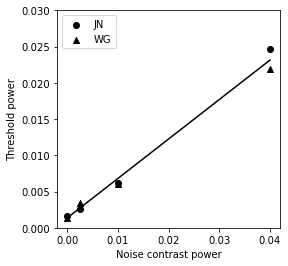

In [4]:
en_support = np.linspace(0,0.2,num=30)
plt.figure(figsize=[4,4])

# JN
df = ng_thres[(ng_thres.subject=='jn') & (ng_thres.eccentricity==0) & (ng_thres.direction==0)]
noise, thres  = df.noise.to_numpy(), df.threshold.to_numpy()
df = ng_params[(ng_params.subject=='jn') & (ng_params.eccentricity==0)] 
slope_jn, intercept_jn = df.slope.to_numpy()[0], df.intercept.to_numpy()[0]
plt.scatter(noise**2, thres**2, marker="o", label='JN', color='k')

# WG
df = ng_thres[(ng_thres.subject=='wsg') & (ng_thres.eccentricity==0) & (ng_thres.direction==0)]
noise, thres  = df.noise.to_numpy(), df.threshold.to_numpy()
df = ng_params[(ng_params.subject=='wsg') & (ng_params.eccentricity==0)] 
slope_wg, intercept_wg = df.slope.to_numpy()[0], df.intercept.to_numpy()[0]
plt.scatter(noise**2, thres**2, marker="^", label='WG', color='k')

# Regression line
plt.plot(en_support**2, ((slope_jn+slope_wg)/2.)*(en_support**2)+(intercept_jn+intercept_wg)/2., color='k')

#
plt.ylim([0,0.03])
plt.xlabel('Noise contrast power')
plt.ylabel('Threshold power')
plt.legend(loc='upper left')
plt.show()

In [5]:
avg = ng_params.\
    groupby(['subject', 'eccentricity']).\
    agg(avg_slope=pd.NamedAgg(column='slope', aggfunc=(lambda x: np.nanmean(x))),
        avg_intercept=pd.NamedAgg(column='intercept', aggfunc=(lambda x: np.nanmean(x)))).\
    reset_index()

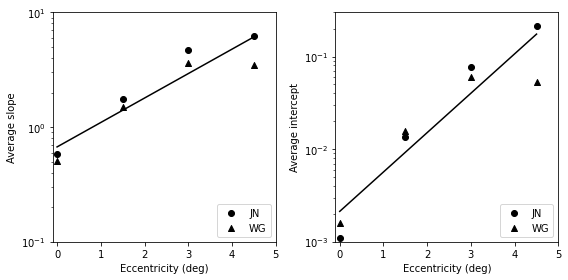

In [6]:
concat = np.concatenate
ec_support = np.linspace(0,4.5,num=30)
f, ax = plt.subplots(1,2, figsize=[8,4])

# JN
df = avg[avg.subject=='jn']
eccen, avg_slope_jn, avg_interc_jn = df.eccentricity.to_numpy(), df.avg_slope.to_numpy(), df.avg_intercept.to_numpy()
ax[0].scatter(eccen, avg_slope_jn, marker="o", label='JN', color='k')
ax[1].scatter(eccen, avg_interc_jn, marker="o", label='JN', color='k')

# WG
df = avg[avg.subject=='wsg']
eccen, avg_slope_wg, avg_interc_wg = df.eccentricity.to_numpy(), df.avg_slope.to_numpy(), df.avg_intercept.to_numpy()
ax[0].scatter(eccen, avg_slope_wg, marker="^", label='WG', color='k')
ax[1].scatter(eccen, avg_interc_wg, marker="^", label='WG', color='k')

# Regression lines 
slope_slope, intercept_slope = simple_regression(concat([eccen,eccen]), np.log(concat([avg_slope_jn,avg_slope_wg])))
slope_inter, intercept_inter = simple_regression(concat([eccen,eccen]), np.log(concat([avg_interc_jn,avg_interc_wg])))

ax[0].plot(ec_support, np.exp(ec_support*slope_slope+intercept_slope), color='k')
ax[1].plot(ec_support, np.exp(ec_support*slope_inter+intercept_inter), color='k')

#
ax[0].set_xlim([-0.1,5])
ax[0].set_ylim([0.1,10.])
ax[0].set_yscale('log')
ax[0].set_xlabel('Eccentricity (deg)')
ax[0].set_ylabel('Average slope')

ax[1].set_xlim([-0.1,5])
ax[1].set_ylim([0.001,0.3])
ax[1].set_yscale('log')
ax[1].set_xlabel('Eccentricity (deg)')
ax[1].set_ylabel('Average intercept')

ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
plt.tight_layout()
plt.show()

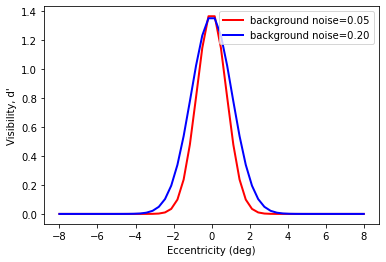

In [7]:
# visibility map based on originally reported (target, background) contrast combinations
xx = np.linspace(-8,8)
plt.plot(xx, gaussian(xx, *gaussian_vismap(0.07,0.05)), color='r', label='background noise=0.05', linewidth=2)
plt.plot(xx, gaussian(xx, *gaussian_vismap(0.19,0.20)), color='b', label='background noise=0.20', linewidth=2)

plt.xlabel('Eccentricity (deg)')
plt.ylabel("Visibility, d'")
plt.legend()
plt.show()

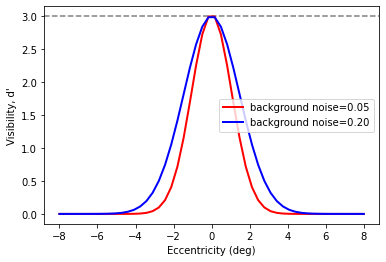

In [8]:
# visibility map based on modified target contrast level that achieves d'=3 (Fig.2)
plt.axhline(y=3, linestyle='dashed', color='gray')
plt.plot(xx, gaussian(xx, *gaussian_vismap(0.107,0.05)), color='r', label='background noise=0.05', linewidth=2)
plt.plot(xx, gaussian(xx, *gaussian_vismap(0.285,0.20)), color='b', label='background noise=0.20', linewidth=2)

plt.xlabel('Eccentricity (deg)')
plt.ylabel("Visibility, d'")
plt.legend()
plt.show()

---
## 2. Modeling using the data-based parameters


In [9]:
par = {    
    'a': 3.,         # linear parameter for the template response (Bujia et al., FiSN, 2022)
    'b': 4.,         # linear parameter for the template response (Bujia et al., FiSN, 2022)
    
    'thres_fix': 30, # threshold for #fixations
    'thres_p': 0.99, # threshold for posterior probability (Rashidi et al., NeurIPS, 2020)
    
    't_loc': 3,      # target location (example)
    'i_loc': 42      # initial location (=central fixation)
}

par.update(dict(zip(['g','s'],gaussian_vismap(0.285,0.20)))) # foveal target d' = 3 case

In [10]:
# initialize visibility map
locations    = triangular_array()
par['n_loc'] = len(locations)
vis_map      = make_vis_map(par)

# initialize K (fixation location at each time)
K = np.zeros(par['thres_fix']+1, dtype=int)*(-1)
K[0] = par['i_loc']

# initialize probability / template response matrices
v = np.zeros([par['n_loc'],par['thres_fix']])*np.nan
p = np.zeros([par['n_loc'],par['thres_fix']])*np.nan
W = np.zeros([par['n_loc'],par['n_loc'],par['thres_fix']])*np.nan

# iteration for one trial
for T in range(par['thres_fix']):
    
    print(f'Time: {T}, \tCurrent fixation location: [{locations[K[T]][0]},{locations[K[T]][1]}]')
    
    # initialize W(a,b,c,d)
    W[:,:,T] = template_response(par, vis_map)
    
    # compute pi(T)
    if T == 0:
        # 1st fixation
        logit    = W[:,K[T],T] * vis_map[:,K[T]]**2
        v[:,T]   = np.exp(logit)
    
    else:
        # next fixations
        logit   += W[:,K[T],T] * vis_map[:,K[T]]**2
        v[:,T]   = p[:,T-1] * np.exp(logit)
    
    p[:,T] = v[:,T] / np.sum(v[:,T])
    
    # finish search if termination criteria is met    
    if np.max(p[:,T]) > par['thres_p']:
        idx = np.argmax(p[:,T])
        print('Maximum criterion reached')

        if idx == par['t_loc']:
            print('Target found')
        else:
            print('Target not found')
        break
        
    # compute the next fixation
    K[T+1] = select_fixation(T, p, vis_map, par, searcher='Bayesian')

Time: 0, 	Current fixation location: [0.0,0.0]
Time: 1, 	Current fixation location: [4.5,-2.598]
Time: 2, 	Current fixation location: [-4.5,2.598]
Time: 3, 	Current fixation location: [-3.75,-3.897]
Time: 4, 	Current fixation location: [3.75,3.897]
Time: 5, 	Current fixation location: [-1.5,5.196]
Time: 6, 	Current fixation location: [1.5,-5.196]
Time: 7, 	Current fixation location: [5.25,1.299]
Time: 8, 	Current fixation location: [-0.75,3.897]
Time: 9, 	Current fixation location: [-0.75,6.495]
Time: 10, 	Current fixation location: [-0.75,6.495]
Time: 11, 	Current fixation location: [-2.25,6.495]
Time: 12, 	Current fixation location: [-2.25,6.495]
Maximum criterion reached
Target found


---
## 3. Visualization of the probability maps

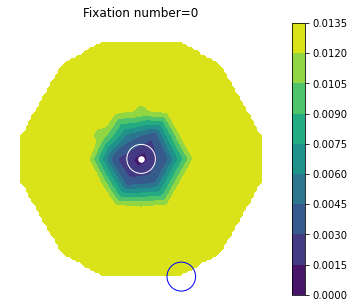

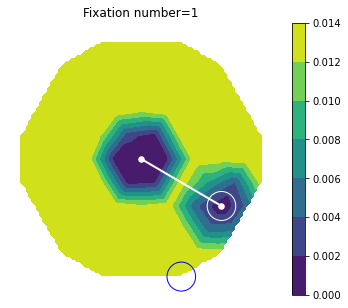

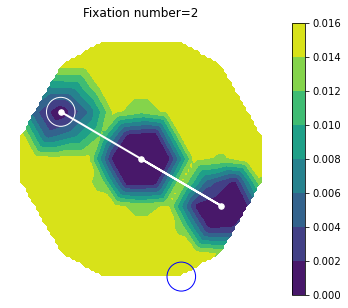

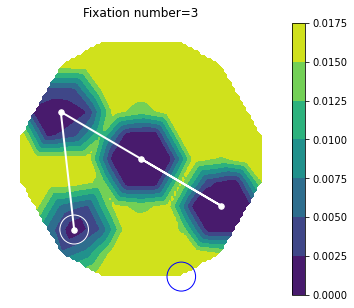

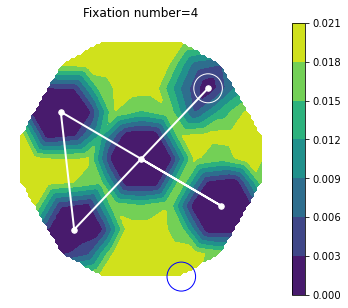

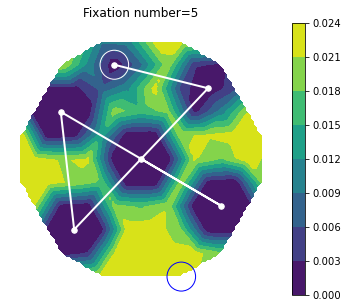

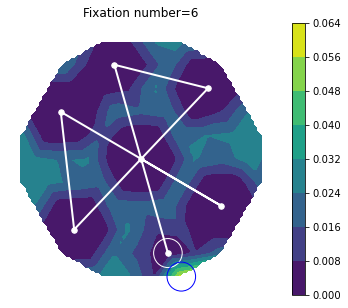

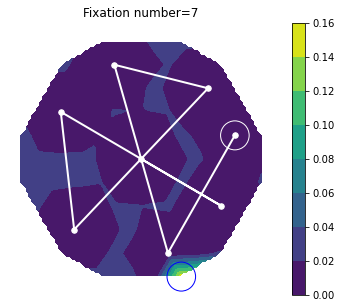

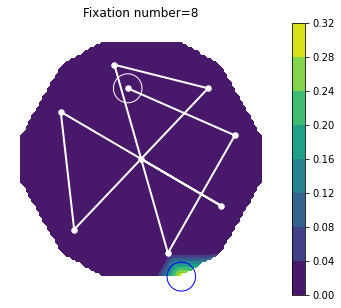

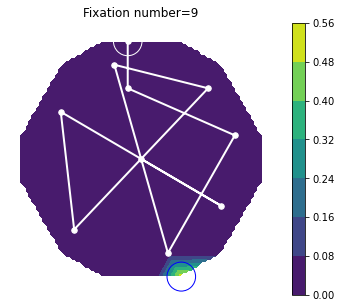

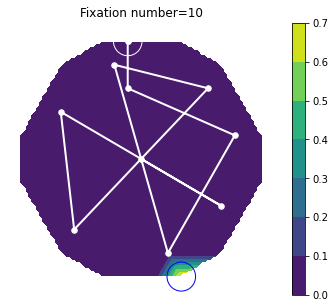

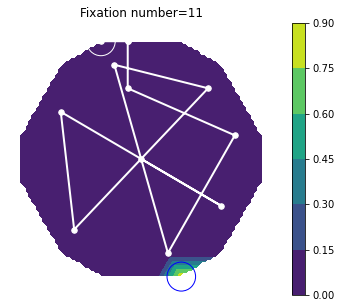

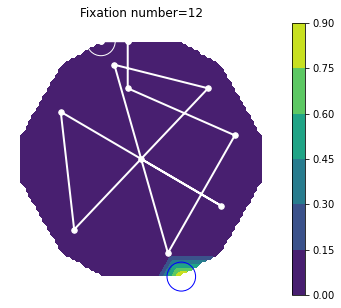

In [11]:
l_min, l_max = -7.5, 7.5
xx, yy = np.meshgrid(*[np.linspace(l_min,l_max,100)]*2)

for tt in range(T+1):
    f, ax = plt.subplots(1,1,figsize=[6,5])
    zz    = griddata((locations[:,0], locations[:,1]), p[:,tt], (xx, yy), method='linear')
    ctf   = ax.contourf(xx, yy, zz)    
    circ_init = plt.Circle((locations[K[tt],0], locations[K[tt],1]), 0.8, color='white', fill=False)
    circ_targ = plt.Circle((locations[par['t_loc'],0], locations[par['t_loc'],1]), 0.8, color='blue', fill=False)
    ax.plot(locations[K[:(tt+1)],0], locations[K[:(tt+1)],1], color='white', linewidth=2)
    ax.scatter(locations[K[:(tt+1)],0], locations[K[:(tt+1)],1], color='white', s=30)
    ax.add_patch(circ_init); ax.add_patch(circ_targ)
    plt.xlim([l_min,l_max]); plt.ylim([l_min,l_max])
    ax.set_title(f'Fixation number={tt}')
    plt.colorbar(ctf)
    plt.axis('off')
    plt.show()

----

## 4. Fixation number prediction using Monte-Carlo Simulations

In [11]:
# "empirical" values that acheives a given d-prime for a given background noise
dprimes   = [3., 3.5, 4., 5., 6., 7.]
contrasts = [[0.107, 0.117, 0.126, 0.144, 0.161, 0.176], # background noise = 0.05 
             [0.285, 0.310, 0.333, 0.378, 0.418, 0.456]] # background noise = 0.20
noises    = [0.05, 0.20] # background noise conditions

Eccentricity: 6.874
Eccentricity: 5.408
Eccentricity: 3.969
Eccentricity: 3.0
Eccentricity: 1.5


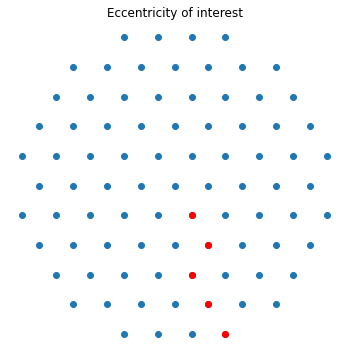

In [12]:
eoi = np.array([3,8,15,24,33]) # positions with eccentricities of interest

plt.figure(figsize=[6,6])
plt.scatter(locations[:,0], locations[:,1])

for kk in eoi:
    plt.scatter(locations[kk,0], locations[kk,1], color='red')
    print('Eccentricity:', np.round(np.sqrt(locations[kk,0]**2 + locations[kk,1]**2),3))
    
plt.axis('off')
plt.title('Eccentricity of interest')
plt.show()

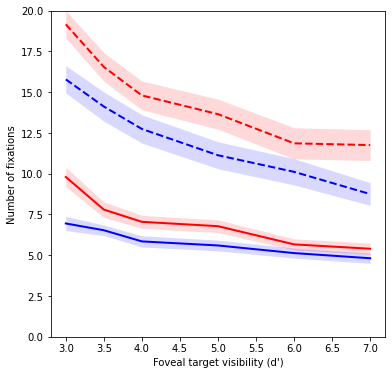

In [ ]:
plt.figure(figsize=[6,6])

plt.fill_between(dprimes, m_b005-s_b005, m_b005+s_b005, color='red', alpha=0.15, lw=0)
plt.fill_between(dprimes, m_b020-s_b020, m_b020+s_b020, color='blue', alpha=0.15, lw=0)
plt.fill_between(dprimes, m_r005-s_r005, m_r005+s_r005, color='red', alpha=0.15, lw=0)
plt.fill_between(dprimes, m_r020-s_r020, m_r020+s_r020, color='blue', alpha=0.15, lw=0)

plt.plot(dprimes, m_b005, color='red', lw=2)
plt.plot(dprimes, m_b020, color='blue', lw=2)
plt.plot(dprimes, m_r005, color='red', lw=2, linestyle='dashed')
plt.plot(dprimes, m_r020, color='blue', lw=2, linestyle='dashed')

plt.ylim([0,20])
plt.xlabel("Foveal target visibility (d')")
plt.ylabel("Number of fixations")
plt.show()